## Практическое задание
- Попробуйте обучить нейронную сеть U-Net на любом другом датасете.
- Опишите результат. Что помогло повысить точность?

#### Использую датасет caltech_birds 2011

In [1]:
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# Importing PlaidML
import os
import plaidml.keras

plaidml.keras.install_backend()
os.environ['KERAS BACKEND'] = "plaidml.keras.backend"
os.environ["PLAIDML_EXPERIMENTAL"] = "1"

In [4]:
from keras import backend as K
K

<module 'keras.backend' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/backend.py'>

In [5]:
# Colab google больше одной эпохи не позволял обучать на gpu из-за размера датасета
# Поэтому использую jupyter notebook

ds_names = ('caltech_birds2011:0.*.*',)
dataset_all, info = tfds.load(ds_names[0], split = ['train[:10%]','test[-10%:]'], with_info=True)

In [6]:
# Датасет содержит 200 классов птиц
info.features['label'].num_classes

200

In [7]:
str(info.features['label'].names)

"['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '1

In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [9]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [10]:
@tf.function
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train = dataset_all[0].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset_all[1].map(load_image_test)

In [13]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [15]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

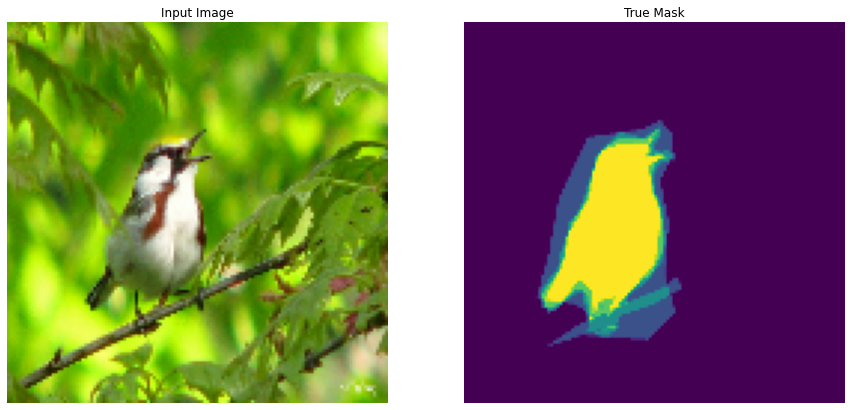

In [16]:
# Пример изображения вместе с его маской
for image, mask in test_dataset.take(15):
    sample_image, sample_mask = image, mask

display([sample_image[2,:,:,:], sample_mask[2,:,:,:]])

In [17]:
sample_mask.numpy().min(), sample_mask.numpy().max()

(0.0, 255.0)

In [18]:
sample_mask.dtype

tf.float32

###  Построение модели
Будем использовать модифицированный U-Net. В качестве энкодера будет использоваться предтренированный MobileNetV2. Декодером будет апсемпл блок уже имплементированный в TensorFlow examples Pix2pix tutorial.

256 возможных лейблов на каждый пиксель

In [19]:
OUTPUT_CHANNELS = 256

In [20]:
# Энкодером будет предтренированный MobileNetV2 из tf.keras.applications. 
# Энкодер состоит из определенных аутпутов из средних слоев модели, не участвует в тренировке 

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [21]:
# Декодер/апсемплер - серия апсемпл блоков имплементированнхы в TensorFlow examples.
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [22]:
# Вместо accuracy используем коэфф Dice

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [23]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, 
        strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [24]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[dice_coef])

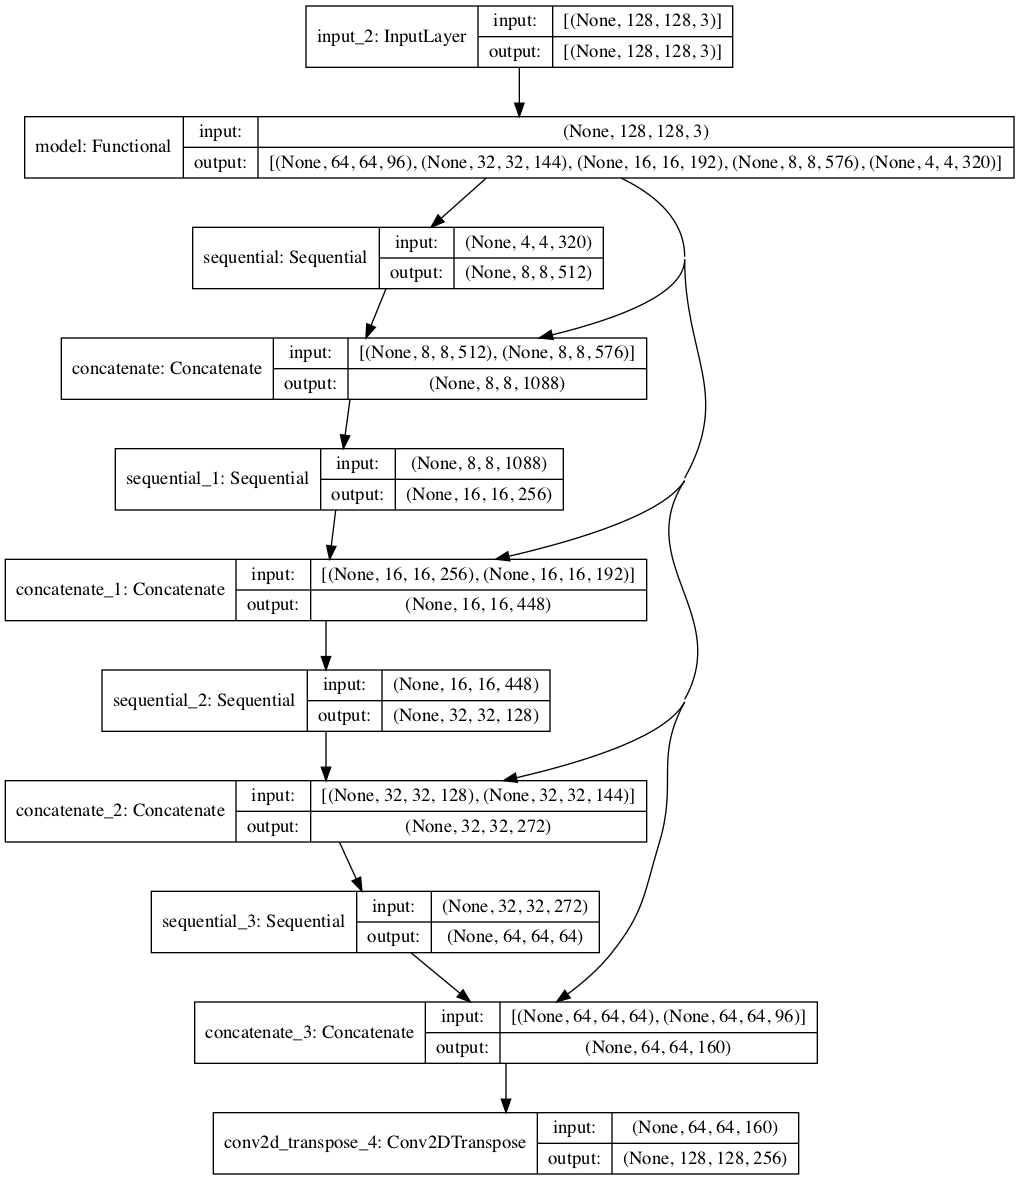

In [25]:
# Получившаяся архитектура модели
tf.keras.utils.plot_model(model, show_shapes=True)

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 1088)   0           sequential[0][0]                 
                                                                 model[0][3]                

In [27]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [28]:
def show_predictions(dataset=test_dataset, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

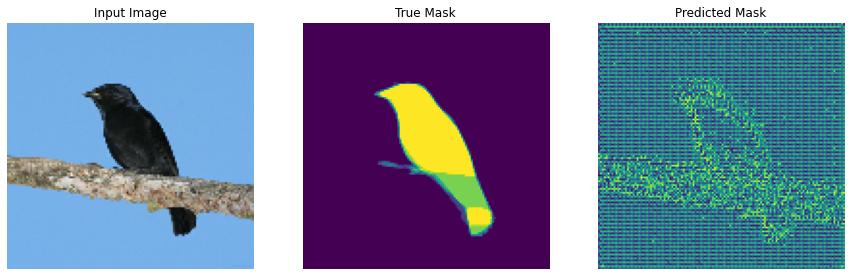

In [29]:
show_predictions()

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Тренировка модели с Dice коэфф. как метрики качества

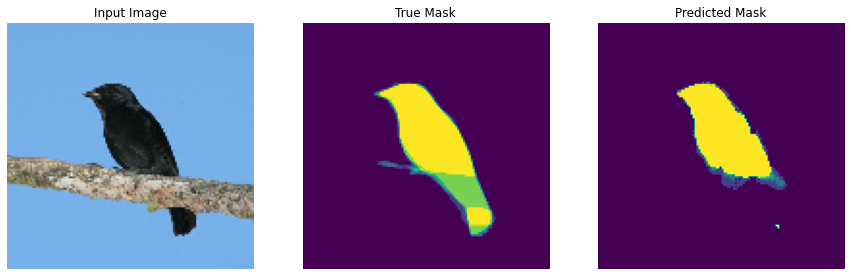


Sample Prediction after epoch 7



In [31]:
EPOCHS = 7
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // 10 //BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

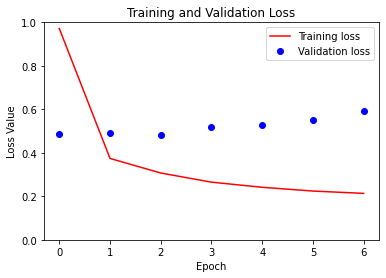

In [32]:
# Loss на валидации быстрее растет после 3 эпохи
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Make predictions

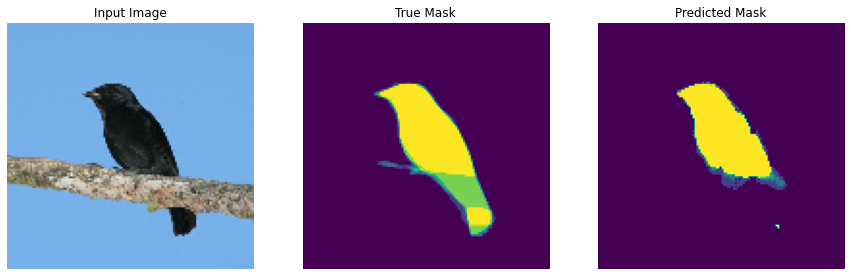

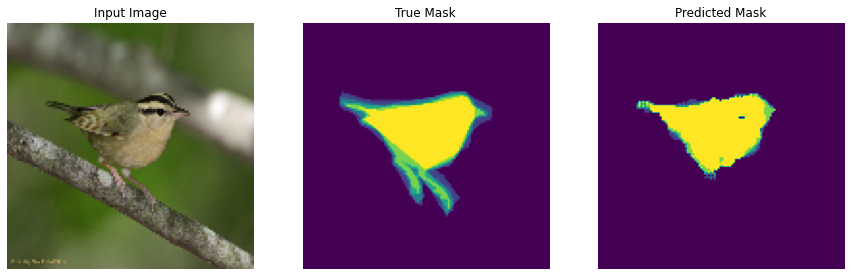

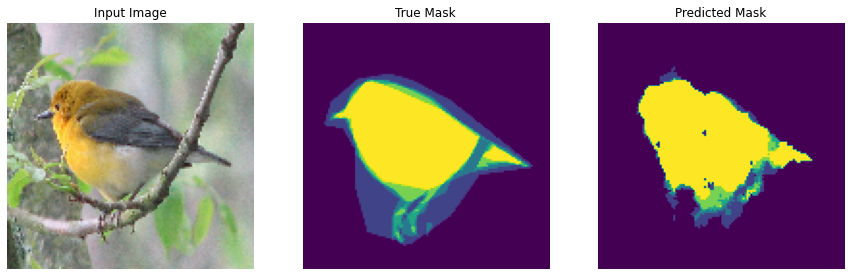

In [33]:
show_predictions(test_dataset, 3)

### Построим модель с accuracy в качестве метрики (вместо Dice coeff)

In [34]:
model2 = unet_model(OUTPUT_CHANNELS)
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
def show_predictions2(dataset=test_dataset, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model2.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model2.predict(sample_image[tf.newaxis, ...]))])

In [36]:
class DisplayCallback2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions2()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

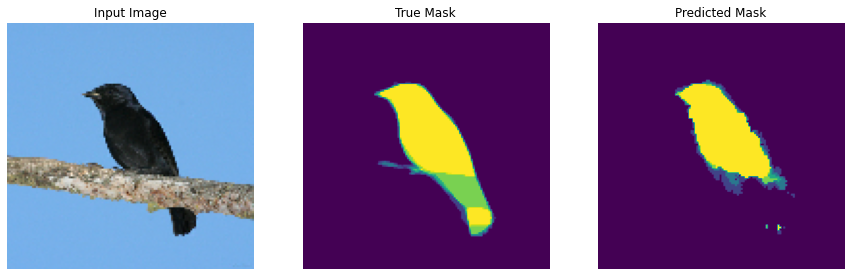


Sample Prediction after epoch 7



In [37]:
model_history2 = model2.fit(train_dataset, 
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback2()])

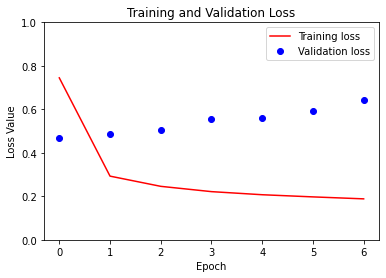

In [38]:
# В модели с accuracy (в качестве метрики) Loss на валидации растет также быстрее после эпохи 3, принимает более высокие значения
loss = model_history2.history['loss']
val_loss = model_history2.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

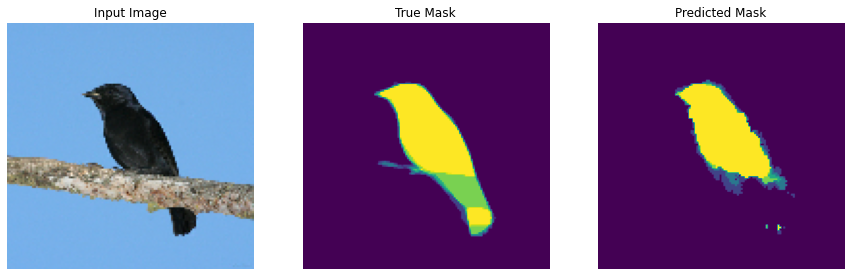

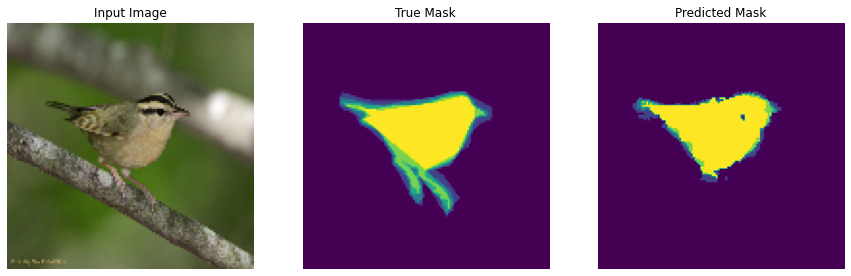

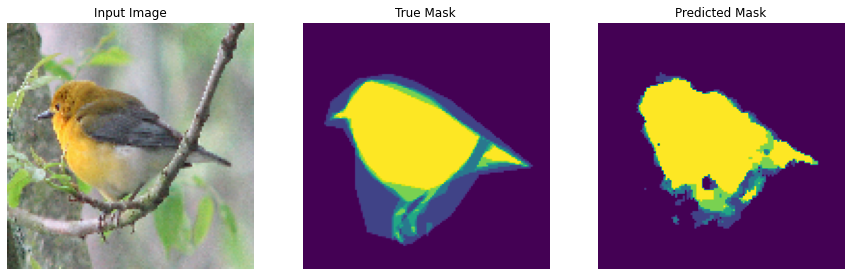

In [40]:
# Обе модели достаточно хорошо предсказывают маски изображений
show_predictions2(test_dataset, 3)

#### На двух эпохах попробучем обучить модели с разными оптимизиторами (метрика качества - accuracy)

In [44]:
result = []
optimizers = ['RMSProp','adam', 'sgd']
EPOCHS = 2
for opt in optimizers:
    model_n = unet_model(OUTPUT_CHANNELS)
    model_n.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model_history_n = model_n.fit(train_dataset, 
                                  epochs=EPOCHS,
                                  steps_per_epoch=STEPS_PER_EPOCH,
                                  validation_steps=VALIDATION_STEPS,
                                  validation_data=test_dataset)

    model_name = f'Model with {opt} optimizer'
    model_metric = model_history_n.history['accuracy'][EPOCHS-1]
    model_val_metric = model_history_n.history['val_accuracy'][EPOCHS-1]
    print("-----{opt}-----")
    result.append([model_name, model_metric, model_val_metric])

Epoch 1/2
93/93 [==============================] - 490s 5s/step - loss: 0.4874 - accuracy: 0.9271 - val_loss: 0.5581 - val_accuracy: 0.9059
Epoch 2/2
93/93 [==============================] - 493s 5s/step - loss: 0.2064 - accuracy: 0.9625 - val_loss: 0.7307 - val_accuracy: 0.9151
-----{opt}-----
Epoch 1/2
93/93 [==============================] - 496s 5s/step - loss: 0.6500 - accuracy: 0.9083 - val_loss: 0.5108 - val_accuracy: 0.9149
Epoch 2/2
93/93 [==============================] - 492s 5s/step - loss: 0.2254 - accuracy: 0.9634 - val_loss: 0.5365 - val_accuracy: 0.9110
-----{opt}-----
Epoch 1/2
93/93 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.8962WARNING:tensorflow:5 out of the last 14 calls to <function Model.make_test_function.<locals>.test_function at 0x7f9a59c78e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different 

93/93 [==============================] - 493s 5s/step - loss: 0.6931 - accuracy: 0.8962 - val_loss: 0.5442 - val_accuracy: 0.9139
Epoch 2/2
93/93 [==============================] - 491s 5s/step - loss: 0.3202 - accuracy: 0.9476 - val_loss: 0.5057 - val_accuracy: 0.9162
-----{opt}-----


In [46]:
# Несколько лучший результат из оптимизаторов показал Adam на двух эпохах.
import pandas as pd
result_table = pd.DataFrame(result, columns=['model_name', 'model_metric', 'model_val_metric']).sort_values('model_val_metric', ascending=True)
result_table

,model_name,model_metric,model_val_metric
1,Model with adam optimizer,0.963424,0.910976
0,Model with RMSProp optimizer,0.962508,0.915147
2,Model with sgd optimizer,0.947584,0.916228


### Выводы
- качество предсказаний лучше при использовании accuracy вместо dice коэффициента
- оптимайзер Adam показывает несколько лучшее качество на 2-х эпохах
- увеличение кол-ва эпох не значительно улучшает качество предсказаний, после эпохи 2 быстрее снижается качество на валидационной выборке